# Imports

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from sklearn.neighbors import NearestNeighbors

# Image Alignment

In [123]:
plt.rcParams["figure.figsize"] = (8, 8)

In [124]:
def plot_side_by_side(images, titles):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(title)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

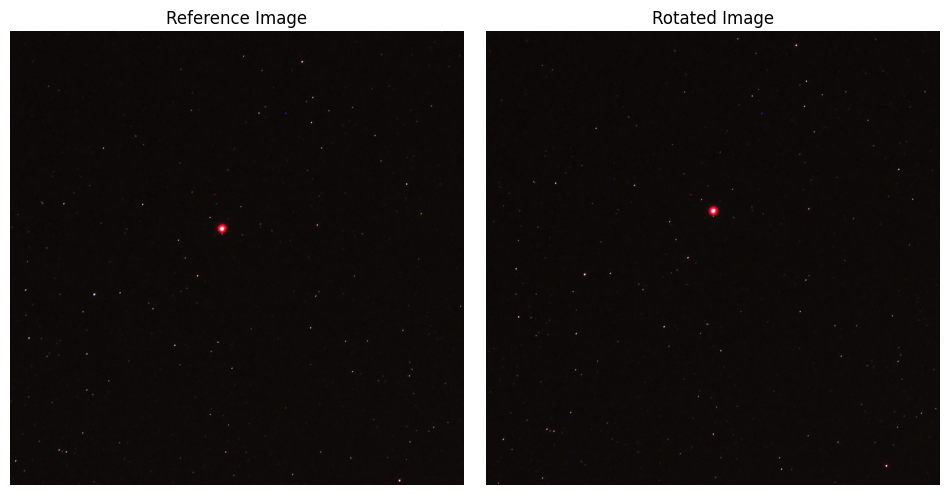

In [125]:
# Crop images for better visibility
reference_image = cv2.imread("/data/stars_00.jpg")[1200:2300, 1700:2800, :]
rotated_image = cv2.imread("/data/stars_14.jpg")[1200:2300, 1700:2800, :]

images = [reference_image, rotated_image]
titles = ["Reference Image", "Rotated Image"]
plot_side_by_side(images, titles)

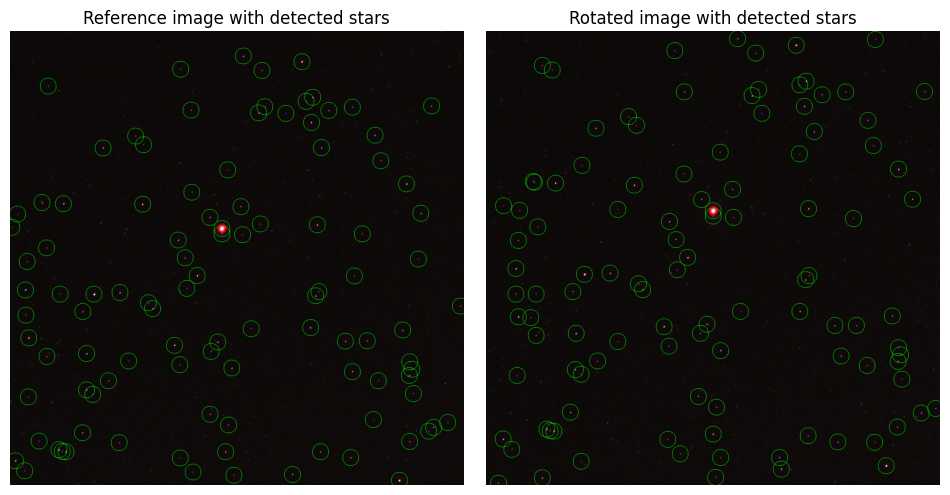

In [126]:
def detect_stars(image, treshold=5):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(gray_image, 40, 255, 0)

    blob_extraction_image = image.copy()
    # Detect connected components (blobs) in the binary image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary_image
    )
    center_points = []
    # Loop through the detected blobs and draw a circle on the output image
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > treshold:
            # Get the centroid of the blob
            center = tuple(map(int, centroids[i]))
            center_points.append(center)
            # Find the minimum enclosing circle of the blob
            radius, _ = cv2.minEnclosingCircle(np.argwhere(labels == i))
            # Draw the circle on the output image
            blob_extraction_image = cv2.circle(
                blob_extraction_image, center, 20, (0, 255, 0), 1
            )
    return np.array(center_points), blob_extraction_image


reference_point_cloud, reference_image_stars = detect_stars(reference_image)
rotated_point_cloud, rotated_image_stars = detect_stars(rotated_image)

images = [reference_image_stars, rotated_image_stars]
titles = ["Reference image with detected stars", "Rotated image with detected stars"]
plot_side_by_side(images, titles)

In [130]:
def plot_all(img_fixed, img_moving, pts_fixed, pts_moving, plot_name):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.gca()
    ax.set_title(plot_name, fontsize=10)
    ax.imshow(img_fixed, cmap="Greens")
    ax.imshow(img_moving, alpha=0.5, cmap="Reds")
    # imshow dimension has x as the vertical axis and y as the horizontal axis.
    # Therefore use the reverse order of axis for plotting the scatter plots.
    ax.scatter([pts_fixed[:, 0]], [pts_fixed[:, 1]], s=20)
    ax.scatter([pts_moving[:, 0]], [pts_moving[:, 1]], s=20)

    # Plot arrows
    for pt_fixed, pt_moving in zip(pts_fixed, pts_moving):
        ax.arrow(
            pt_moving[0],
            pt_moving[1],
            pt_fixed[0] - pt_moving[0],
            pt_fixed[1] - pt_moving[1],
            length_includes_head=True,
            color="r",
            head_width=10,
            alpha=0.5,
        )

    plt.axis("off")
    plt.show()

## Solution for Known Correspondences

Given two corresponding point sets $X$ and $Y$ with points $n$ points

\begin{equation*}
X = \{x_1, x_2, \ldots, x_i\} \quad Y = \{y_1, y_2, \ldots, y_j\}
\end{equation*}

and correspondences $C = \{(i, j)\}$

We want to determine the rotation and translation that minimizes de Sum of Squared Differences (SSD) between corresponding points:

\begin{align*}
E(R, t) =  (1 / n) \sum_{(i, j) \in C}^{n} \|x_i - (Ry_i + t) \|^2
\end{align*}

For known correspondences, the optimal rotation and translation can be calculated in closed form by following the steps below:

1. Initially, compute the mean of each point set:

\begin{equation*}
\mu_x = \frac{1}{n} \sum_{i=1}^{n} x_i \quad \mu_y = \frac{1}{n} \sum_{i=1}^{n} y_i
\end{equation*}

2. Center the point sets at the origin by subtracting the respective mean from every point:

\begin{align*}
X' &= \{x_i - \mu_x \,|\, x_i \in X\} \quad Y' &= \{y_i - \mu_y \,|\, y_i \in Y\}
\end{align*}

3. Compute covariance matrix of the transformed points:

\begin{equation*}
\text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (x'_i)^T y'_i
\end{equation*}

4. Use Singular Value Decomposition (SVD) to represent the covariance matrix as rotations ($U$ and $V^T$) and stretching ($\Sigma$) matrices:

\begin{equation*}
\text{{Cov}}(X,Y) \stackrel{\text{SVD}}{=} U \Sigma V^T
\end{equation*}

5. Remove the stretching to obtain the final rotation matrix:

\begin{equation*}
R = U V^T
\end{equation*}

6. Compute optimal translation vector:

\begin{equation*}
t = \mu_{y} - R \mu_{x}
\end{equation*}

In [131]:
def get_rotation_and_translation(X, Y):
    # Step 1: Compute mean
    mean_x = np.mean(X, axis=0)
    mean_y = np.mean(Y, axis=0)

    # Step 2: Center points at the origin
    centered_x = X - mean_x
    centered_y = Y - mean_y

    # Step 3: Compute covariance
    covarience = (centered_y.T @ centered_x) / (X.shape[0])

    # Step 4: Use SVD to represent the covariance matrix as rotations and stretching matrices
    U, _, Vt = np.linalg.svd(covarience, full_matrices=False)

    # Step 5: Remove the stretching matrix to obtain the final rotation matrix
    R = U @ Vt

    # Check for mirroring
    if np.linalg.det(R) < 0:
        # Mirror the matrix
        Vt[-1, :] *= -1
        R = U @ Vt

    # Step 6: Compute optimal translation vector
    t = mean_y - R @ mean_x

    return R, t


def transform_image(Y, t, R):
    # Get image dimensions
    height, width = Y.shape[:2]

    # Define the transformation matrix
    M = np.zeros((2, 3))
    M[:2, :2] = R
    M[:2, 2] = t

    # Perform the image transformation
    transformed_image = cv2.warpAffine(Y, M, (width, height))

    return transformed_image


def get_ssd(X, Y):
    # Ensure X and Y have the same shape
    assert X.shape == Y.shape, "Matrices must have the same shape."

    # Compute element-wise squared differences
    squared_diff = np.square(X - Y)

    # Sum up the squared differences
    ssd = np.sum(squared_diff)

    return ssd

## Iterative Closest Points

If the correspondeces are unknown we can use the Iterative Closest Points (ICP) Algorithm:

1. Establish correspondences using the Nearest Neighbors.
2. Estimate rotation and translation using the SVD method.
3. Apply the obtained transformation to the moving point set.
4. Repeat steps 1, 2 and 3 until convergence.

A good initial alignment is crucial for convergence to a good local minimum. Also, using the minimal distance and removing outliers is required for an efficient correspondence search.

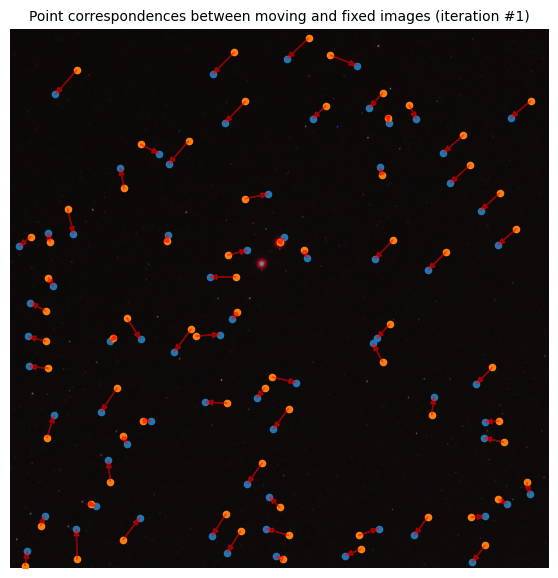

Sum of Squared Differences:  131286


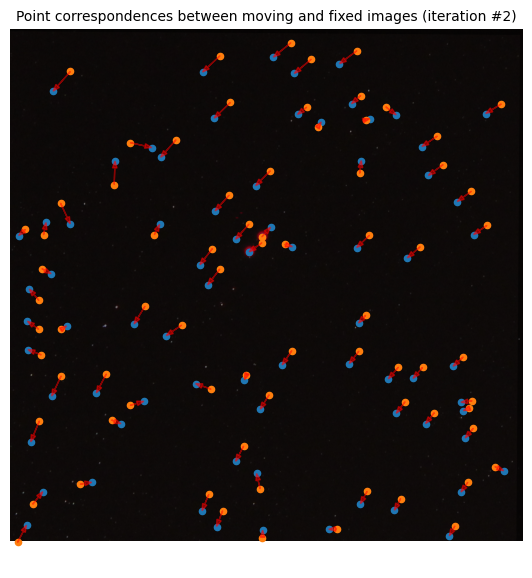

Sum of Squared Differences:  91514.83468552431


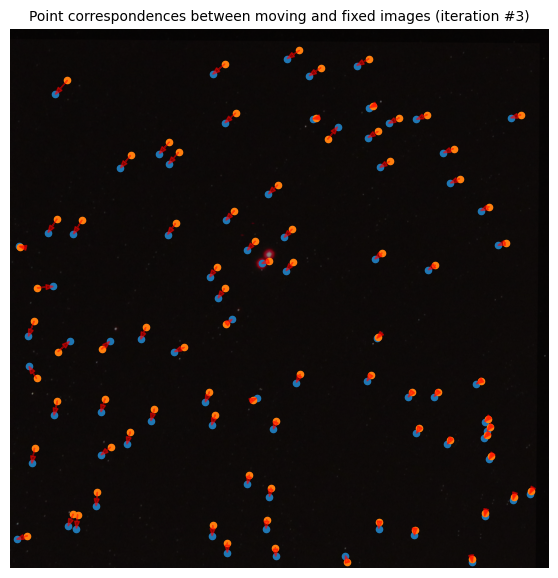

Sum of Squared Differences:  42716.401083471006


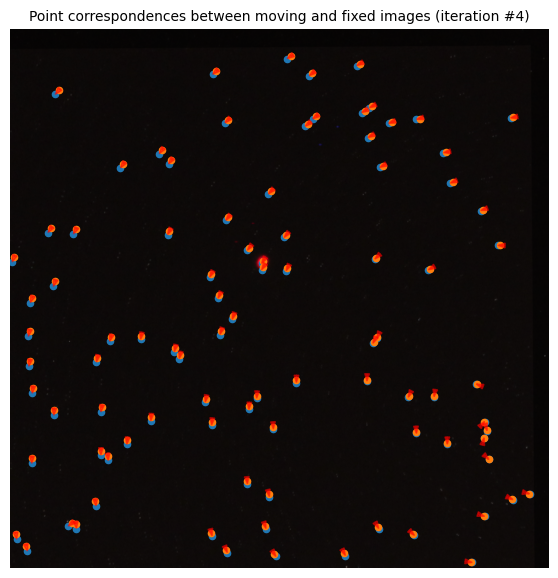

Sum of Squared Differences:  5033.107820667932


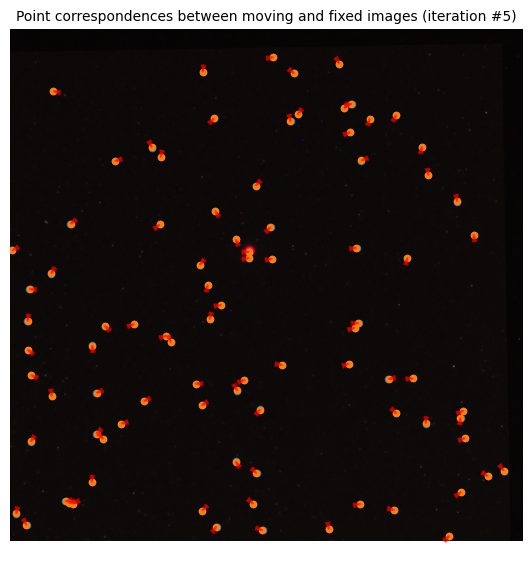

Sum of Squared Differences:  42.43483989327244


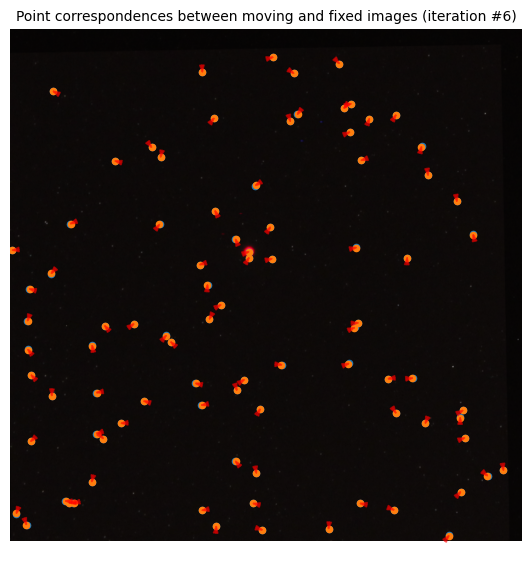

Sum of Squared Differences:  40.1520057821665


In [132]:
def iterative_closest_points(
    X, Y, image_X, image_Y, tolerance=1, threshold=2, plot=True, verbose=True
):
    current_ssd = 0
    previous_ssd = np.inf
    iteration = 1

    # Loop continues until convergence
    while abs(current_ssd - previous_ssd) > tolerance:
        # Step 1: Establish correspondences using nearest neighbor
        nearest_neighbors = NearestNeighbors(n_neighbors=1).fit(X)
        distances, indexes = nearest_neighbors.kneighbors(Y, return_distance=True)

        # To avoid duplicates, in case of multiple points y ∈ Y corresponding to a
        # single point x ∈ X keep only the closest point to x.
        distances_df = pd.DataFrame(
            data=np.hstack((indexes, distances)), columns=["indexes", "distances"]
        )
        min_distances_df = distances_df.groupby(["indexes"]).agg("min").reset_index()
        distances_df = (
            distances_df.reset_index()
            .merge(min_distances_df, on=["indexes", "distances"])
            .set_index("index")
        )

        # Remove outlier points using Z-score method
        closest_distances = distances_df["distances"].values
        z_scores = np.abs(
            (closest_distances - np.mean(closest_distances)) / np.std(closest_distances)
        )
        distances_df = distances_df[z_scores < threshold]

        X_indexes = distances_df["indexes"].values.astype("int")
        Y_indexes = distances_df.index

        X_corresponding_points = X[X_indexes]
        Y_closest_points = Y[Y_indexes]

        # Step 2: Estimate rotation and translation
        R, t = get_rotation_and_translation(X_corresponding_points, Y_closest_points)

        # Plot point correspondences
        if plot:
            plot_all(
                image_X,
                image_Y,
                X_corresponding_points,
                Y_closest_points,
                f"Point correspondences between moving and fixed images (iteration #{iteration})"
            )

        # Compute Sum of Squared Distances
        ssd = get_ssd(X_corresponding_points, Y_closest_points)
        previous_ssd = current_ssd
        current_ssd = ssd
        if verbose:
            print("Sum of Squared Differences: ", ssd)

        # Step 3: Apply the obtained rotation and translation to the points and the image
        Y = (Y - t) @ R
        image_Y = transform_image(image_Y, -t, R.T)

        iteration += 1

    return Y, image_Y


resulting_point_cloud, resulting_image = iterative_closest_points(
    reference_point_cloud, rotated_point_cloud, reference_image, rotated_image, 10
)

In [133]:
def align_images(reference_image, rotated_image):
    reference_point_cloud, _ = detect_stars(reference_image)
    rotated_point_cloud, _ = detect_stars(rotated_image)

    _, aligned_image = iterative_closest_points(
        reference_point_cloud,
        rotated_point_cloud,
        reference_image,
        rotated_image,
        plot=False,
        verbose=False,
    )

    return aligned_image